# Optimal Binning for Mutual Information: A Student's Guide

## 🎯 The Fundamental Problem

When estimating mutual information (MI) from continuous data, we face a **critical choice**: how many bins should we use to discretize our variables? This choice dramatically affects our results, and there's no universal "right" answer.

**The Trade-off**:
- **Too few bins**: Lose important details, underestimate true relationships
- **Too many bins**: Get fooled by noise, overestimate spurious relationships

Think of it like choosing the resolution of a photograph - too low and you miss important features, too high and you see noise as meaningful patterns.

---

## 📊 Why Binning Matters for Mutual Information

### The Discrete MI Formula

Mutual information for discrete variables is defined as:

$$I(X;Y) = \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} p(x,y) \log\frac{p(x,y)}{p(x)p(y)}$$

For continuous variables, we estimate this by:

1. **Discretizing** $X$ and $Y$ into bins
2. **Estimating probabilities** from bin counts
3. **Computing MI** using the discrete formula

### The Estimation Process

```pseudocode
FUNCTION estimate_MI_with_bins(X, Y, n_bins):
    # Step 1: Create bins
    X_binned = DISCRETIZE(X, n_bins)
    Y_binned = DISCRETIZE(Y, n_bins)
    
    # Step 2: Count joint occurrences
    joint_counts = HISTOGRAM_2D(X_binned, Y_binned)
    
    # Step 3: Convert to probabilities
    p_xy = joint_counts / TOTAL_SAMPLES
    p_x = MARGINAL_X(p_xy)
    p_y = MARGINAL_Y(p_xy)
    
    # Step 4: Compute MI
    MI = 0
    FOR each (i,j) where p_xy[i,j] > 0:
        MI += p_xy[i,j] * log(p_xy[i,j] / (p_x[i] * p_y[j]))
    
    RETURN MI
```

### The Binning Dilemma Illustrated

Text(0.5, 1.0, 'MI Estimate vs Number of Bins')

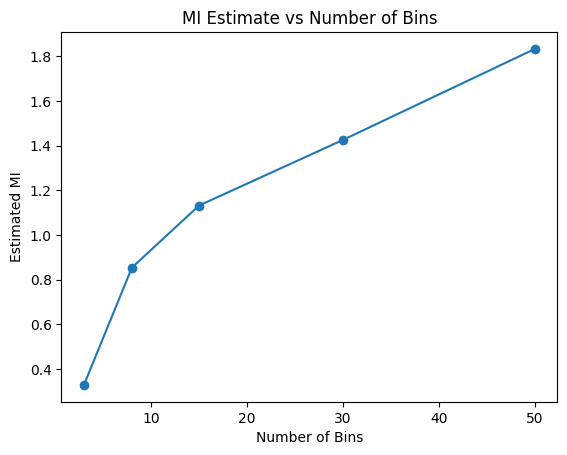

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def estimate_MI_histogram(x, y, bins):
    """
    Estimate Mutual Information (MI) using histogram method.
    
    Parameters:
    x : array-like
        First variable.
    y : array-like
        Second variable.
    bins : int
        Number of bins to use for histogram.
        
    Returns:
    float
        Estimated Mutual Information.
    """
    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    
    # Normalize histogram to get joint probability distribution
    joint_prob = hist / np.sum(hist)
    
    # Calculate marginal probabilities
    p_x = np.sum(joint_prob, axis=1)
    p_y = np.sum(joint_prob, axis=0)
    
    # Calculate MI
    mi = 0.0
    for i in range(bins):
        for j in range(bins):
            if joint_prob[i, j] > 0:
                mi += joint_prob[i, j] * np.log(joint_prob[i, j] / (p_x[i] * p_y[j]))
    
    return mi

# Create a known nonlinear relationship
n = 500
x = np.random.uniform(-2, 2, n)
y = x**2 + np.random.normal(0, 0.3, n)

# Test different bin sizes
bin_sizes = [3, 8, 15, 30, 50]
mi_values = []

for bins in bin_sizes:
    # Estimate MI with different bin counts
    mi = estimate_MI_histogram(x, y, bins)
    mi_values.append(mi)

# Plot results
plt.plot(bin_sizes, mi_values, 'o-')
plt.xlabel('Number of Bins')
plt.ylabel('Estimated MI')
plt.title('MI Estimate vs Number of Bins')

**What you'll observe**:
- **Low bins**: MI increases as we capture more of the relationship
- **Optimal range**: MI peaks when bins match data complexity
- **Too many bins**: MI decreases due to noise/sparsity

---

## 🧮 Mathematical Foundation: The Bias-Variance Trade-off

### Bias Component

**Bias** occurs when our estimator systematically under/overestimates the true MI.

- **Too few bins**: High bias (miss true relationship details)
- **Many bins**: Lower bias (capture fine-grained relationships)

$$\text{Bias}(k) = \mathbb{E}[\hat{I}_k(X;Y)] - I(X;Y)$$

where $\hat{I}_k$ is our MI estimate with $k$ bins.

### Variance Component

**Variance** measures how much our estimate fluctuates across different samples.

- **Few bins**: Lower variance (stable estimates)
- **Many bins**: Higher variance (sensitive to sampling noise)

$$\text{Variance}(k) = \mathbb{E}[(\hat{I}_k(X;Y) - \mathbb{E}[\hat{I}_k(X;Y)])^2]$$

### The Total Error

Mean Squared Error combines both:

$$\text{MSE}(k) = \text{Bias}^2(k) + \text{Variance}(k)$$

**The goal**: Find $k^*$ that minimizes MSE.

---

## 🔧 Classical Binning Rules

### 1. Square Root Rule
**Formula**: $k = \sqrt{n}$

**Intuition**: Simple rule that scales with sample size.

**When to use**: Quick estimation, no prior knowledge about data.

In [4]:
def sqrt_rule(x):
    return int(np.sqrt(len(x)))

### 2. Sturges' Rule
**Formula**: $k = \lceil \log_2(n) + 1 \rceil$

**Intuition**: Based on binomial distribution assumptions.

**Mathematical foundation**: 
If data follows normal distribution, this minimizes integrated mean square error.

In [5]:
def sturges_rule(x):
    return int(np.log2(len(x)) + 1)

### 3. Scott's Rule
**Formula**: $h = \frac{3.5\sigma}{n^{1/3}}$, then $k = \frac{\text{range}}{h}$

**Intuition**: Optimal bin width for normal distributions.

**Derivation**: Minimizes asymptotic mean integrated squared error (AMISE).

$$\text{AMISE}(h) = \frac{1}{nh} + \frac{h^4}{4}\int [f''(x)]^2 dx$$

Taking derivative and setting to zero gives optimal $h$.

In [6]:
def scott_rule(x):
    n = len(x)
    sigma = np.std(x)
    bin_width = 3.5 * sigma / (n ** (1/3))
    bins = int((np.max(x) - np.min(x)) / bin_width)
    return max(2, min(bins, n//5))  # Reasonable bounds

### 4. Freedman-Diaconis Rule
**Formula**: $h = \frac{2 \cdot \text{IQR}}{n^{1/3}}$

**Intuition**: Uses interquartile range instead of standard deviation - more robust to outliers.

**Why IQR**: Less sensitive to extreme values than standard deviation.

In [7]:
def freedman_diaconis_rule(x):
    n = len(x)
    iqr = np.percentile(x, 75) - np.percentile(x, 25)
    bin_width = 2 * iqr / (n ** (1/3))
    bins = int((np.max(x) - np.min(x)) / bin_width)
    return max(2, min(bins, n//5))

---

## 🎓 Advanced Methods: Information-Theoretic Approaches

### 5. Knuth's Rule (Bayesian Approach)

**Philosophy**: Use Bayesian model selection to find optimal bins.

**Objective**: Minimize description length (information needed to encode data + model).

$$\text{Cost}(k) = -\log P(\text{data}|k) - \log P(k)$$

**Algorithm**:
```pseudocode
FUNCTION knuth_optimal_bins(X):
    best_score = infinity
    best_k = sqrt(n)
    
    FOR k = 2 to max_reasonable_bins:
        # Compute histogram
        counts = HISTOGRAM(X, k)
        
        # Log-likelihood of data given k bins
        log_likelihood = SUM(counts * log(counts / n))
        
        # Bayesian penalty for model complexity
        penalty = 0.5 * (k-1) * log(n)
        
        # Total cost (negative log posterior)
        cost = -log_likelihood + penalty
        
        IF cost < best_score:
            best_score = cost
            best_k = k
    
    RETURN best_k
```

**Implementation**:

In [8]:
def knuth_rule(x):
    n = len(x)
    
    def cost_function(k):
        if k < 2:
            return np.inf
        
        hist, _ = np.histogram(x, bins=int(k))
        hist = hist[hist > 0]  # Remove empty bins
        
        if len(hist) < 2:
            return np.inf
        
        # Log-likelihood
        log_likelihood = np.sum(hist * np.log(hist / n))
        
        # BIC penalty
        penalty = 0.5 * (k - 1) * np.log(n)
        
        return -log_likelihood + penalty
    
    # Search for optimal k
    k_range = range(2, min(50, n//5))
    costs = [cost_function(k) for k in k_range]
    return k_range[np.argmin(costs)]

### 6. Cross-Validation Approach

**Idea**: Find bins that give most consistent MI estimates across data splits.

**Algorithm**:
```pseudocode
FUNCTION cv_optimal_bins(X, Y):
    best_score = 0
    best_k = sqrt(n)
    
    FOR k = 3 to max_bins:
        scores = []
        
        FOR fold = 1 to n_folds:
            train_X, train_Y = GET_TRAIN_FOLD(X, Y, fold)
            test_X, test_Y = GET_TEST_FOLD(X, Y, fold)
            
            # Estimate MI on training data
            MI_train = ESTIMATE_MI(train_X, train_Y, k)
            
            # Evaluate on test data
            MI_test = ESTIMATE_MI(test_X, test_Y, k)
            
            # Score based on consistency
            score = MIN(MI_train, MI_test) - ABS(MI_train - MI_test)
            scores.APPEND(score)
        
        avg_score = MEAN(scores)
        
        IF avg_score > best_score:
            best_score = avg_score
            best_k = k
    
    RETURN best_k
```

---

## 🧠 Adaptive Binning: Context-Aware Strategies

### The Adaptive Philosophy

Instead of using a one-size-fits-all rule, adapt binning to:
- **Data characteristics** (distribution shape, range, outliers)
- **Sample size**
- **Relationship complexity**
- **Both variables simultaneously**

### Adaptive Algorithm

```pseudocode
FUNCTION adaptive_binning(X, Y):
    n = LENGTH(X)
    
    # Analyze data characteristics
    x_unique = COUNT_UNIQUE(X)
    y_unique = COUNT_UNIQUE(Y)
    x_skewness = COMPUTE_SKEWNESS(X)
    y_skewness = COMPUTE_SKEWNESS(Y)
    
    # Handle discrete-like variables
    IF x_unique <= 10:
        bins_x = x_unique
    ELSE:
        # Choose method based on data properties
        IF ABS(x_skewness) > 2:  # Highly skewed
            bins_x = freedman_diaconis_rule(X)
        ELSE IF n < 100:         # Small sample
            bins_x = sqrt_rule(X)
        ELSE:                    # Normal case
            bins_x = knuth_rule(X)
    
    # Same logic for Y
    bins_y = SIMILAR_LOGIC(Y)
    
    # Ensure reasonable bounds
    bins_x = CLIP(bins_x, 2, n/10)
    bins_y = CLIP(bins_y, 2, n/10)
    
    RETURN (bins_x, bins_y)
```

### Implementation Example

In [9]:
def adaptive_binning(x, y):
    n = len(x)
    
    # Analyze characteristics
    x_unique = len(np.unique(x))
    y_unique = len(np.unique(y))
    
    # Discrete variable handling
    if x_unique <= 10:
        bins_x = x_unique
    elif n < 50:
        bins_x = int(np.sqrt(n))
    elif n < 200:
        bins_x = freedman_diaconis_rule(x)
    else:
        bins_x = knuth_rule(x)
    
    # Same for y
    if y_unique <= 10:
        bins_y = y_unique
    elif n < 50:
        bins_y = int(np.sqrt(n))
    elif n < 200:
        bins_y = freedman_diaconis_rule(y)
    else:
        bins_y = knuth_rule(y)
    
    # Reasonable bounds
    bins_x = max(2, min(bins_x, n//10))
    bins_y = max(2, min(bins_y, n//10))
    
    return bins_x, bins_y

---

## 📈 Practical Guidelines for Students

### Decision Framework

```mermaid
graph TD
    A[Start: Need to estimate MI] --> B{Sample size?}
    B -->|n < 50| C[Use sqrt rule]
    B -->|50 ≤ n < 200| D{Data skewed?}
    B -->|n ≥ 200| E{Computational budget?}
    
    D -->|Yes| F[Use Freedman-Diaconis]
    D -->|No| G[Use Scott's rule]
    
    E -->|Limited| H[Use adaptive method]
    E -->|Unlimited| I[Use cross-validation]
    
    C --> J[Estimate MI]
    F --> J
    G --> J
    H --> J
    I --> J
```

### Rule of Thumb Summary

| Scenario | Recommended Method | Why? |
|----------|-------------------|------|
| **Small data** (n < 50) | Square root rule | Simple, avoids overfitting |
| **Medium data** (50 ≤ n < 500) | Freedman-Diaconis | Robust to outliers |
| **Large data** (n ≥ 500) | Knuth's rule | Principled, adapts to complexity |
| **Mixed data types** | Adaptive method | Handles different variable types |
| **Critical application** | Cross-validation | Most reliable, computationally expensive |
| **Real-time application** | Square root rule | Fastest computation |

### Common Mistakes to Avoid

**❌ Mistake 1**: Using the same number of bins for all datasets

In [10]:
# Bad: Always use 10 bins
mi = estimate_mi(x, y, bins=10)

# Good: Adapt to data
optimal_bins = choose_optimal_bins(x, y)
mi = estimate_mi(x, y, bins=optimal_bins)

NameError: name 'estimate_mi' is not defined

**❌ Mistake 2**: Ignoring data characteristics

In [ ]:
# Bad: Ignore that variable has few unique values
bins = sturges_rule(x)  # x has only 5 unique values

# Good: Check uniqueness first
if len(np.unique(x)) <= 10:
    bins_x = len(np.unique(x))
else:
    bins_x = sturges_rule(x)

**❌ Mistake 3**: Not validating bin choice

In [ ]:
# Bad: Use bins without checking
mi = estimate_mi(x, y, bins=bins)

# Good: Validate with multiple approaches
mi_sqrt = estimate_mi(x, y, bins=sqrt_rule(x))
mi_fd = estimate_mi(x, y, bins=freedman_diaconis_rule(x))
mi_knuth = estimate_mi(x, y, bins=knuth_rule(x))

# Use median or check consistency

---

## 🔬 Advanced Topic: Multivariate Binning

### The Challenge

For multivariate MI $I(X_1, X_2, \ldots, X_p; Y)$, we need to bin in $p$-dimensional space.

**Curse of dimensionality**: Number of bins grows exponentially: $k^p$

### Solutions

**1. Independent binning** (simple but suboptimal):
```pseudocode
FOR each variable X_i:
    bins_i = OPTIMAL_BINS_1D(X_i)

total_bins = PRODUCT(all bins_i)
```

**2. Adaptive dimensionality reduction**:
```pseudocode
# Use PCA or similar to reduce dimensions first
X_reduced = PCA(X, n_components=min(3, p))
bins = OPTIMAL_BINS(X_reduced)
```

**3. Hierarchical binning**:
```pseudocode
# Start with coarse bins, refine where data is dense
initial_bins = COARSE_BINNING(X)
FOR each bin:
    IF BIN_COUNT > threshold:
        SUBDIVIDE_BIN(bin)
```

---

## 💡 Practical Implementation

### Complete Optimal MI Estimator

In [ ]:
class OptimalMIEstimator:
    def __init__(self, method='auto'):
        self.method = method
        self.binning_methods = {
            'sqrt': self._sqrt_rule,
            'sturges': self._sturges_rule,
            'scott': self._scott_rule,
            'freedman_diaconis': self._fd_rule,
            'knuth': self._knuth_rule,
            'adaptive': self._adaptive_rule
        }
    
    def estimate(self, x, y):
        """Estimate MI with optimal binning"""
        # Clean data
        mask = ~(np.isnan(x) | np.isnan(y))
        x, y = x[mask], y[mask]
        
        # Choose binning method
        if self.method == 'auto':
            method = self._choose_method(x, y)
        else:
            method = self.method
        
        # Get optimal bins
        bins = self.binning_methods[method](x, y)
        
        # Estimate MI
        mi = self._compute_mi_histogram(x, y, bins)
        
        return mi, bins, method
    
    def _choose_method(self, x, y):
        """Automatically choose best method based on data"""
        n = len(x)
        
        if n < 50:
            return 'sqrt'
        elif n < 200:
            return 'freedman_diaconis'
        else:
            return 'knuth'
    
    def _compute_mi_histogram(self, x, y, bins):
        """Compute MI using histogram method"""
        # Implementation as shown earlier
        pass

### Usage Example

In [ ]:
# Create test data
x = np.random.uniform(-2, 2, 300)
y = x**2 + np.random.normal(0, 0.5, 300)

# Estimate MI with optimal binning
estimator = OptimalMIEstimator(method='auto')
mi_value, optimal_bins, method_used = estimator.estimate(x, y)

print(f"MI: {mi_value:.4f}")
print(f"Optimal bins: {optimal_bins}")
print(f"Method used: {method_used}")

---

## 🎯 Key Takeaways for Students

### The Big Picture
1. **Binning choice matters hugely** for MI estimation
2. **No universal optimal choice** - depends on data and context
3. **Modern approaches are adaptive** - they consider data characteristics
4. **Validation is crucial** - always check robustness of results

### Practical Wisdom
- **Start simple**: Try sqrt rule for initial exploration
- **Be adaptive**: Use data-driven methods for final analysis
- **Validate results**: Check consistency across different bin choices
- **Understand your data**: Discrete vs continuous, outliers, sample size

### When in Doubt
- Use **multiple methods** and compare results
- **Plot MI vs bins** to visualize the trade-off
- **Cross-validate** for critical applications
- **Report sensitivity** to binning choices

Remember: The goal isn't to find the "perfect" bins, but to make an **informed choice** that balances bias and variance for your specific problem!